This script is for all necessary calculations

1, resolution calculation

2, Basic Beamforming DAS varification - Refer to http://www.labbookpages.co.uk/audio/beamforming/delaySum.html

3, Compressive senceing calculation

In [2]:
# initialize, import necessary package

import numpy as np


In [3]:
# The minimum resolution of two points, for [WFOV unbinned]
distance = 0.5 # in m, range in 	0.25 - 2.21 m
ans = distance * np.sqrt(3) * 2 / 1024 
print(f" the minimum distance of two point in Depth Camera are {ans*1000}mm at {distance}m")

 the minimum distance of two point in Depth Camera are 1.6914558667664816mm at 0.5m



The model density of 3D object

$$
\frac{\Delta N}{\Delta \omega}=\frac{\omega^2 V}{2 \pi^2 c_0^3}
$$

In [4]:
# The model density of HATS
V = 0.07 #m3
C0 = 1400 # m/s
f = 10000 # Hz
omega = 2*np.pi*f
density = omega**2*V/(2*(np.pi**2)*C0**3)
print(f" within the span of 1000Hz, there is {density*1000} modes, at frequency {f}Hz")

 within the span of 1000Hz, there is 5.102040816326531 modes, at frequency 10000Hz


In [5]:

# First half - Acquistion / Simulation
# Start with a simple mesh geometry




In [5]:
from scipy.interpolate import interp1d

def resample_signal(original_time, original_signal, new_time):
    """
    Resample a signal to a new time axis.

    Parameters:
    - original_time: The original time axis of the signal.
    - original_signal: The signal values at the original time points.
    - new_time: The new time axis to which the signal should be resampled.

    Returns:
    - The resampled signal values at the new time points.
    """
    
    # Create an interpolation function based on the original data
    interpolator = interp1d(original_time, original_signal, kind='linear', fill_value="extrapolate")
    
    # Use the interpolator to get the signal values at the new time points
    new_signal = interpolator(new_time)
    
    return new_signal


import numpy as np
def delay_and_sum(pcd, mic_array, sound_field, time_ini):
    result = []
    t_resampling = np.arange(0, 15, 10/np.shape(sound_field)[1]) # resampling time
    # load the sound field data into loop
    for i, mic_data in enumerate(sound_field):
        # Pf_values = mic_data["Pf_values"]+mic_data["Pm_values"]
        Pf_values = mic_data
        distance = np.linalg.norm(mic_array[i] - pcd.points, axis=1)

        c = 343 #sound speed
        delay = distance / c #time delay
        t_old = np.array(time_ini[:, np.newaxis] + delay.T)
        result_individual_mesh = []
        for t in t_old.T:
            resample_mesh = resample_signal(t, Pf_values, t_resampling)
            result_individual_mesh.append(resample_mesh)
        result.append(result_individual_mesh)
        if i in np.arange(1,100,5):
            print(f"mapped micphone result, {i}.......")
    return np.array(result), t_resampling
    

import xml.etree.ElementTree as ET

def mic_array(filename, x,y,z):
# 解析XML文件
    tree = ET.parse(filename)
    root = tree.getroot()

    values = [(int(item.attrib["Name"][6:]), item.attrib['x'], item.attrib['y'],item.attrib['z']) for item in root.findall('pos')]
    values = np.array(values, dtype=float)
    values[:,1] += x
    values[:,2] += y
    values[:,3] += z
    return values


Then we define an error function, E(a, r),
between the model cross-spectra and the measured cross-spectra

$$
E(a, \mathbf{r})=\sum_{m, n=1}^M\left|C_{n m}-C_{n m}^{\bmod }\right|^2=\sum_{m, n=1}^M\left|C_{n m}-a v_n^*(\mathbf{r}) v_m(\mathbf{r})\right|^2
$$
the
minimisation of this error function corresponds to the maximisation of the Cross spectral Imaging Function, with the self-term removal, the 


Self-term-free version of the imaging function

$$
J^2(\omega, \mathbf{r}) \equiv \frac{1}{\sqrt{M(M-1)}} \frac{\left|\sum_{m \neq n}^M C_{n m}(\omega) v_n(\mathbf{r}) v_m^*(\mathbf{r})\right|}{\sqrt{\sum_{m \neq n}^M\left|v_n(\mathbf{r})\right|^2\left|v_m(\mathbf{r})\right|^2}}
$$


$$
v(\mathbf{r})=e^{-j k|\mathbf{r}|} /|\mathbf{r}|
$$

$$
C_{n m}(\omega) \equiv \overline{P_m(\omega) P_n^*(\omega)}
$$

In [46]:
import numpy as np
from scipy.signal import csd, welch
from scipy.fft import fftshift
import time
from scipy.signal import butter, lfilter

def DAS(pcd, mic_array, sound_field, time_ini):
    T = 10
    N = np.shape(sound_field)[1]
    print(np.shape(sound_field))
    t_step = T/ N
    fs = N/T
    nperseg = N/np.round(np.sqrt(N))/10
    # print(f"T{T}, N{N}, fs{fs}")
    
    nyq = 1/2.56 * fs
    low = 3000 / nyq
    high = 4000 / nyq
    b, a = butter(5, [low, high], btype='band')
    sound_field = lfilter(b, a, sound_field)
    
    f, Pxy = csd(sound_field[1],sound_field[2], fs/1.28, noverlap = None, nperseg = nperseg, nfft = nperseg*1.3, return_onesided=False, axis=-1)
    f = fftshift(f)
    # print(f"T{f}, N{P}, fs{fs}")
    C = 343
    omega = 2*np.pi*f
    k = omega/C
    
    m, x = sound_field.shape
    point_count = np.shape(np.array(gridpcd.points))[0]

    Cmn = np.zeros((m, m, len(f)), dtype=complex)
    Vmn = np.zeros((m, m, point_count,len(f)), dtype=complex)
    Vmn2 = np.zeros((m, m, point_count,len(f)), dtype=complex)

    for i in range(m):
        for j in range(m):
            # 计算第i个信号和第j个信号的交叉谱
            cmn_starttime = time.time()
            f, Cmn[i,j,:] = csd(sound_field[i], sound_field[j], fs/1.28, noverlap = None, nperseg = nperseg, nfft = nperseg*1.3, return_onesided=False, axis=-1)
            cmn_endtime = time.time()
            
            rm = np.linalg.norm(mic_array[i] - pcd.points, axis=1)[:,None]
            rn = np.linalg.norm(mic_array[j] - pcd.points, axis=1)[:,None]
            vm = np.exp(-1j*k*rm)/rm
            vn = np.exp(-1j*k*rn)/rn
            
            Vmn[i, j, :,:] = (vm) * (np.conj(vn))
            vm2 = (vm)**2
            vn2 = (vn)**2
            Vmn2[i,j,:] = (vm2*vn2)
            
        if i in np.arange(1,100,5):
            print(f"mapped micphone result, {i}.......time consumen by Cmn = {cmn_starttime - cmn_endtime}")
    
    
    # 将对角线值置为0
    # Cmn = np.fill_diagonal(Cmn, 0)
    # Vmn = np.fill_diagonal(Vmn, 0)
    # Vmn2 = np.fill_diagonal(Vmn2, 0)
    
    
    return Cmn[:,:,None, :],Vmn, Vmn2, f

r = np.linalg.norm(mics, axis = 1)
# t = np.arange(0,2,1/fs)[:,None]
t = np.arange(0,10,10/np.shape(fieldPressure_r)[1])
t_r = t
# fieldPressure = np.log10(np.abs(pointsource(r,30,t).T)/20e-6)
# fieldPressure = pointsource(r,f,t).T
Cmn, Vmn,Vmn2, t_r= DAS(gridpcd, mics, fieldPressure_r, t_r)

(36, 327680)
mapped micphone result, 1.......time consumen by Cmn = -0.0820012092590332
mapped micphone result, 6.......time consumen by Cmn = -0.08296370506286621
mapped micphone result, 11.......time consumen by Cmn = -0.09195828437805176
mapped micphone result, 16.......time consumen by Cmn = -0.0820016860961914
mapped micphone result, 21.......time consumen by Cmn = -0.08096742630004883
mapped micphone result, 26.......time consumen by Cmn = -0.07799911499023438
mapped micphone result, 31.......time consumen by Cmn = -0.11003565788269043


(36, 327680)


<function matplotlib.pyplot.show(close=None, block=None)>

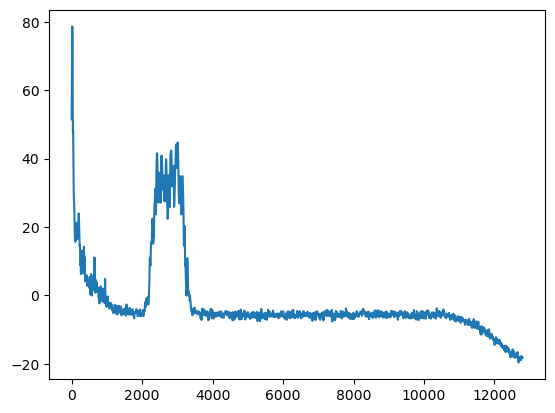

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import csd, welch


T = 10
N = np.shape(fieldPressure_r)[1]
print(np.shape(fieldPressure_r))
t_step = T/ N
fs = N/T
t_constant = 0.1

nperseg = t_constant * fs

f, Pxy = welch(fieldPressure_r, fs/1.28, noverlap = None, nperseg = nperseg, nfft = nperseg*1.3, return_onesided=True, axis=-1)
Pxy = fs/2.56*Pxy

plt.plot(f, 20*np.log10(np.real(Pxy[1,:].T)/20e-6))
plt.show

In [43]:

lowcut = 2000  # 滤波器的低频截止 (Hz)
highcut = 4000  # 滤波器的高频截止 (Hz)
# hanning_window = np.zeros(Pxy.shape[1])
idx = np.where((f >= lowcut) & (f <= highcut))[0]
# hanning_window[idx] = np.hanning(len(idx))

# Pxy = Pxy * hanning_window

Pxy = Pxy[:,idx]
f = f[idx]

m, x = fieldPressure_r.shape
point_count = np.shape(np.array(gridpcd.points))[0]
Csm = np.zeros((m, m, len(f)), dtype=complex)
Vmn = np.zeros((m, m, point_count,len(f)), dtype=complex)
Vmn2 = np.zeros((m, m, point_count,len(f)), dtype=complex)
C = 343
omega = 2*np.pi*f
k = (omega/C)[None,:]

points = np.array(gridpcd.points)
distance = np.zeros((36, 36))

for i in range(mics.shape[0]):
    distance[i,:] = np.linalg.norm(mics[i] - points, axis=1) # supposed to be a M x N matrix
    # print(distance[i,:])

for i in range(m):
    for j in range(m):
        Csm = Pxy[i] * np.conj(Pxy[j])
        rm = distance[i][:,None]
        rn = distance[j][:,None]
        vm = np.exp(-1j*k*rm)/rm
        vn = np.exp(-1j*k*rn)/rn
        
        Vmn[i, j, :,:] = (vm) * (np.conj(vn))
        vm2 = (vm)**2
        vn2 = (vn)**2
        Vmn2[i,j,:] = (vm2*vn2)

J = ((fs/2.56)*Csm*Vmn)/Vmn2

<function matplotlib.pyplot.show(close=None, block=None)>

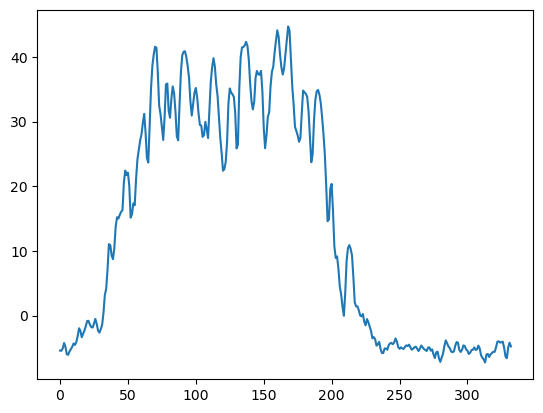

In [44]:
plt.plot(20*np.log10(np.real(Pxy[1,:].T)/20e-6))
plt.show

In [49]:
J = ((fs/2.56)*Cmn*Vmn)/Vmn2


print(np.shape(J))
print(np.shape(J)[1])

print(np.shape(np.array(gridpcd.points))[0])

(36, 36, 25, 74)
36
25


In [23]:
T = 10
N = np.shape(fieldPressure_r)[1]
t_step = T/ N
fs = N/T
nperseg = N/np.round(np.sqrt(N))
# print(f"T{T}, N{N}, fs{fs}")
conv = []

f, Pxy_r = scipy.signal.csd(fieldPressure_r, fieldPressure_r, fs/1.28, noverlap = None, nperseg = nperseg, nfft = nperseg*1.3, return_onesided=True, axis=-1)
fftP = np.fft.fft(fieldPressure_r[1,:])
fft_f = np.fft.fftfreq(len(fieldPressure_r[1,:]), 1/fs)
print([Pxy_r.shape, f.shape])

[(36, 373), (373,)]


[(373,), (373,)]
()


<function matplotlib.pyplot.show(close=None, block=None)>

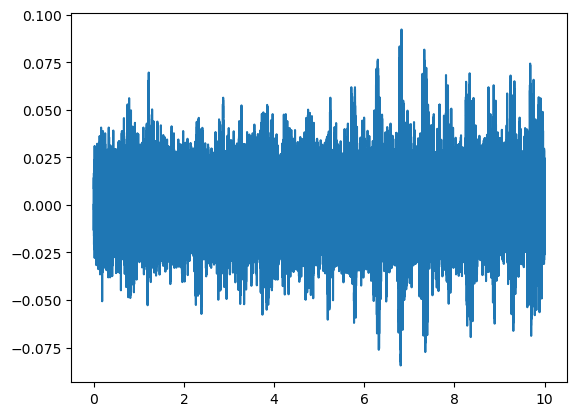

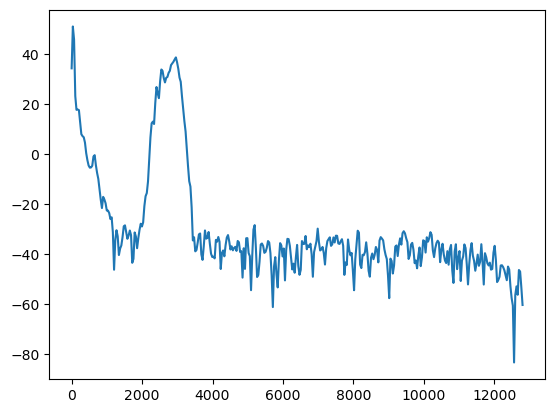

<Figure size 640x480 with 0 Axes>

In [20]:
#for i in np.arange(300, 2000, 100):
   # f, Pxy_approxi = welch(fieldPressure_r, fs, noverlap = None, nperseg = N/i, nfft = N/i*1.3, return_onesided=True, axis=1)
   # conv.append(Pxy_r.sum(axis=(0, 1))/Pxy_approxi.sum(axis=(0, 1)))

P = fs/2.56*fftshift(Pxy_r, axes=0)

c13 = (P[0]* np.conj(P[2]))
# plt.plot(f, 20*np.log10(np.abs(Pxy_r[1, :]/20e-6)))

plt.figure()
plt.plot(time, fieldPressure_r[1,:])
plt.figure()
plt.plot(f, 20*np.log10(np.abs(fs/2.56*Pxy_r.T/(20e-6))))
plt.figure()
# pxy = 20*np.log10(np.real((fftP * np.conj(fftP))/20e-6))
print(c13.shape)
# plt.plot(f, 20*np.log10(np.real(c13/20e-6)))
plt.show

# print(np.shape(Pxy))

In [47]:
result = 1/36 * J.sum(axis=(0, 1))

import ipywidgets as widgets
from ipywidgets import interact, interact_manual



from scipy.interpolate import griddata
def plot_beamforming_output(result, col_index):
    # 这里直接使用外部定义的 result
    points = np.asarray(gridpcd.points)
    x = points[:, 0]
    y = points[:, 1]
    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z = griddata((x, y), 20*np.log10(np.abs(np.real(result[:, col_index])/20e-6)), (grid_x, grid_y), method='cubic')
    
    # 设置想要显示的动态范围，例如40 dB
    dynamic_range = 15

    # 获取数据中的最大值
    max_value = np.max(grid_z)

    # 设置你想要的颜色级别数量
    num_levels = 40
    
    limited_grid_z = np.clip(grid_z, max_value - dynamic_range, max_value)

    # 创建一个包含从最大值到最大值减去动态范围的等间隔值的数组
    # levels = np.linspace(max_value - dynamic_range, max_value, num_levels)
    # grid_z = griddata((x, y), result[:, col_index], (grid_x, grid_y), method='cubic')
    # 绘制轮廓图
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(grid_x, grid_y, limited_grid_z, levels=20, cmap='rainbow')
    cbar = plt.colorbar(contour)
    cbar.set_label('(dB)')
    plt.title(f'Beamforming output for point source, frequency = {f[col_index]}')
    plt.xlabel('x(m)')
    plt.ylabel('y(m)')
    plt.show()

# 创建滑块
slider = widgets.IntSlider(
    value=254,
    min=0,
    max=result.shape[1] - 1,
    step=1,
    description='Index:',
    continuous_update=False
)

# 将滑块与绘图函数绑定
interact(lambda col_index: plot_beamforming_output(result, col_index), col_index=slider)


interactive(children=(IntSlider(value=254, continuous_update=False, description='Index:', max=332), Output()),…

<function __main__.<lambda>(col_index)>

In [6]:
import matplotlib.pyplot as plt

plt.plot(np.sum(P, axis = 1))
plt.show

NameError: name 'P' is not defined

In [180]:

import numpy as np
from scipy.signal import welch
from scipy.fft import fftshift

def cross_spectrum_matrix(signals, fs=1.0, nperseg=None):
    num_signals = len(signals)
    csm = np.zeros((num_signals, num_signals), dtype=complex)
    
    f, Pxy = welch(signals, fs, nperseg=nperseg, return_onesided=False, axis=-1)
    f = fftshift(f)
    Pxy = fftshift(Pxy, axes=0)
    
    for i in range(num_signals):
        for j in range(num_signals):
            csm[i, j] = np.mean(Pxy[i] * np.conj(Pxy[j]))
            
    return f, Pxy

# Test the function with some signals
fs = 1000  # Sampling frequency
t = np.arange(0, 1.0, 1/fs)  # Time vector
signals = [np.sin(2*np.pi*50*t), np.sin(2*np.pi*120*t)]  # Two sinusoidal signals

f, csm = cross_spectrum_matrix(np.array(signals), fs=fs, nperseg=100)

In [6]:
import matplotlib.pyplot as plt

plt.plot(signals)
plt.show

NameError: name 'signals' is not defined

In [7]:
def pointsource(r,f,t):
    
    C = 343
    
    omega = 2*np.pi*f
    k = omega/C
    P = 1/r*np.exp(1j*(omega*t-k*r))
    return P

In [8]:
import open3d as o3d
import numpy as np

# points
vertices = []
for i in range(6):
    for j in range(6):
        x = i * 0.2 - 0.5
        y = j * 0.2 - 0.5
        z = 0
        vertices.append([x, y, z])

# angles
triangles = []
for i in range(29):
    for j in range(29):
        offset = i * 30 + j
        triangles.append([offset, offset+1, offset+30])
        triangles.append([offset+1, offset+31, offset+30])

# mesh
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(vertices)
mesh.triangles = o3d.utility.Vector3iVector(triangles)


gridpcd = o3d.geometry.PointCloud()
gridpcd.points = o3d.utility.Vector3dVector(vertices)


# import the microphone positions
mics_number = mic_array('P36D45_f14.xml', 0, 0, 1)
mics = mics_number[:,1:]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(mics)

o3d.visualization.draw_geometries([gridpcd,pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
# import the measured fieldpressure datas
import scipy.io

file_path = 'Recording-3000_4000_open.mat'
mat_data = scipy.io.loadmat(file_path)

# 创建一个空列表来存储提取的数据
data_list = []

# 为了确保按照通道顺序获取数据，我们直接使用范围内的数字构建键的名称
for i in range(1, 37):  # 从 1 到 36
    key = f'Channel_{i}_Data'  # 构建键的名称
    if key in mat_data:  # 检查键是否存在于字典中
        data_list.append(mat_data[key].T)  # 如果存在，将数据添加到列表中

# 使用 numpy.vstack() 将列表转换成矩阵
fieldPressure_r = np.vstack(data_list)

time = np.arange(0,10,10/np.shape(fieldPressure_r)[1])


In [10]:

# t = np.arange(0,2,1/fs)[:,None]
t_r = time


# fieldPressure = np.log10(np.abs(pointsource(r,30,t).T)/20e-6)
# fieldPressure = pointsource(r,f,t).T
tresult_r, t_r = delay_and_sum(gridpcd, mics, fieldPressure_r, t_r)

KeyboardInterrupt: 

In [164]:
source_position = np.array([[0.5, 0.5, 0], [-0.5,-0.5,0]])
# source_position = np.array([[0.5, 0.50, 0]])
# Add a new axis to 'source_position' to make its shape (2, 1, 3) to make it broadcast-compatible with 'mics'
r = np.linalg.norm(mics - source_position[:, None], axis=2)
print([r.shape, source_position.shape, mics.shape])

[(2, 36), (2, 3), (36, 3)]


In [11]:
fs = 4000
t = np.arange(0,1,1/fs)
f = 5000
# fieldPressure = np.log10(np.abs(pointsource(r,30,t).T)/20e-6)
fieldPressure = pointsource(r,f,t[:, None, None]).T

fieldPressureTwo = np.sum(fieldPressure, axis = 1)
print(np.shape(fieldPressureTwo))

plt.figure()
plt.plot(np.real(fieldPressure_r[:, :]).T)
plt.figure()
plt.plot(np.real(fieldPressureTwo[:, 1400:1500]).T)
plt.figure()
plt.plot(r.T)
plt.show()

NameError: name 'r' is not defined

In [171]:
tresult, t = delay_and_sum(gridpcd, mics, fieldPressureTwo, t)

mapped micphone result, 1.......
mapped micphone result, 6.......
mapped micphone result, 11.......
mapped micphone result, 16.......
mapped micphone result, 21.......
mapped micphone result, 26.......
mapped micphone result, 31.......


In [177]:
import matplotlib.pyplot as plt

plt.plot(r[4].T)
plt.show

IndexError: index 4 is out of bounds for axis 0 with size 4

In [10]:
z = 2
d = 0.45
c = 343
f = 8000


Resolution = 1.22* z/d*c/f

print(Resolution)

0.23247777777777776


In [111]:
B_norm_r = np.sum(tresult_r,axis = 1).T
B_norm_r = 1/len(mics)*B_norm_r

In [172]:
B_norm = np.sum(tresult,axis = 0).T
B_norm = 1/len(mics)*B_norm

In [102]:
print(np.shape(B_norm))

(6000, 400)


In [108]:

from scipy.interpolate import griddata
# 获取点云中的 x 和 y 坐标
points = np.asarray(gridpcd.points)
x = points[:, 0]
y = points[:, 1]

# 创建一个规则的网格，将点云数据插值到这个网格上
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# 使用 scipy 的 griddata 函数进行插值
grid_z = griddata((x, y), 20*np.log10(np.abs(np.real(B_norm_r[141100]/20e-6))), (grid_x, grid_y), method='cubic')

# 使用 matplotlib 绘制轮廓图
contour = plt.contourf(grid_x, grid_y, grid_z, levels=15, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label('(dB)')  
plt.title(f'Beamforming output for Acoustic lens')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.show()


ValueError: different number of values and points

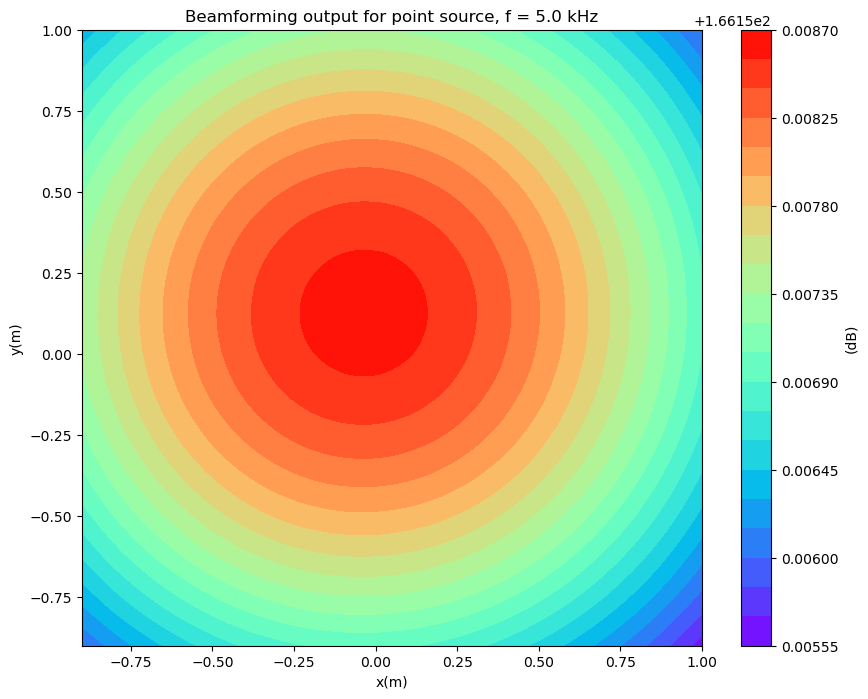

In [173]:

from scipy.interpolate import griddata
# 获取点云中的 x 和 y 坐标
points = np.asarray(gridpcd.points)
x = points[:, 0]
y = points[:, 1]

# 创建一个规则的网格，将点云数据插值到这个网格上
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# 使用 scipy 的 griddata 函数进行插值
grid_z = griddata((x, y), 20*np.log10(np.abs(np.real(B_norm[3000, :])/20e-6)), (grid_x, grid_y), method='cubic')

# 设置想要显示的动态范围，例如40 dB
dynamic_range = 15

# 获取数据中的最大值
max_value = np.max(grid_z)

# 设置你想要的颜色级别数量
num_levels = 40

limited_grid_z = np.clip(grid_z, max_value - dynamic_range, max_value)

# 创建一个包含从最大值到最大值减去动态范围的等间隔值的数组
# levels = np.linspace(max_value - dynamic_range, max_value, num_levels)
# grid_z = griddata((x, y), result[:, col_index], (grid_x, grid_y), method='cubic')
# 绘制轮廓图
plt.figure(figsize=(10, 8))

contour = plt.contourf(grid_x, grid_y, limited_grid_z, levels=20, cmap='rainbow')
cbar = plt.colorbar(contour)
cbar.set_label('(dB)')
plt.title(f'Beamforming output for point source, f = {f/1000} kHz')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.show()
